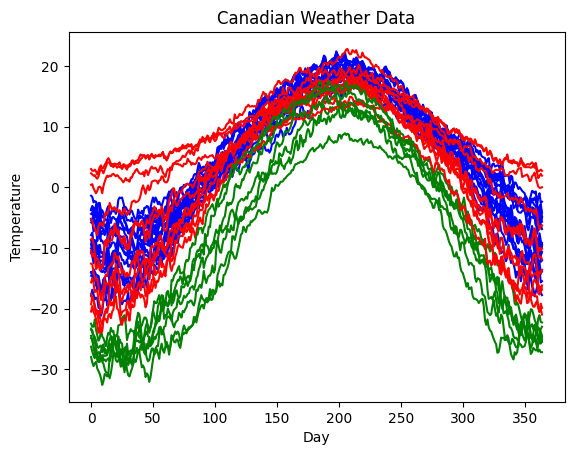

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the weather data from Datasets/CanadianWeather.csv, ignoring the first row and first column
weather_data = pd.read_csv('Datasets/CanadianWeather.csv', header=None, skiprows=1, usecols=range(1, 35))

# Convert weather data to numpy array
weather_data = weather_data.to_numpy()

true_labels = [3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]	

weather_data = weather_data.T

# Plot the weather data based on the true labels
for i in range(0, 34):
    if true_labels[i] == 1:
        plt.plot(weather_data[i], 'r')
    elif true_labels[i] == 2:
        plt.plot(weather_data[i], 'g')
    else:
        plt.plot(weather_data[i], 'b')

plt.xlabel('Day')
plt.ylabel('Temperature')
plt.title('Canadian Weather Data')
plt.show()

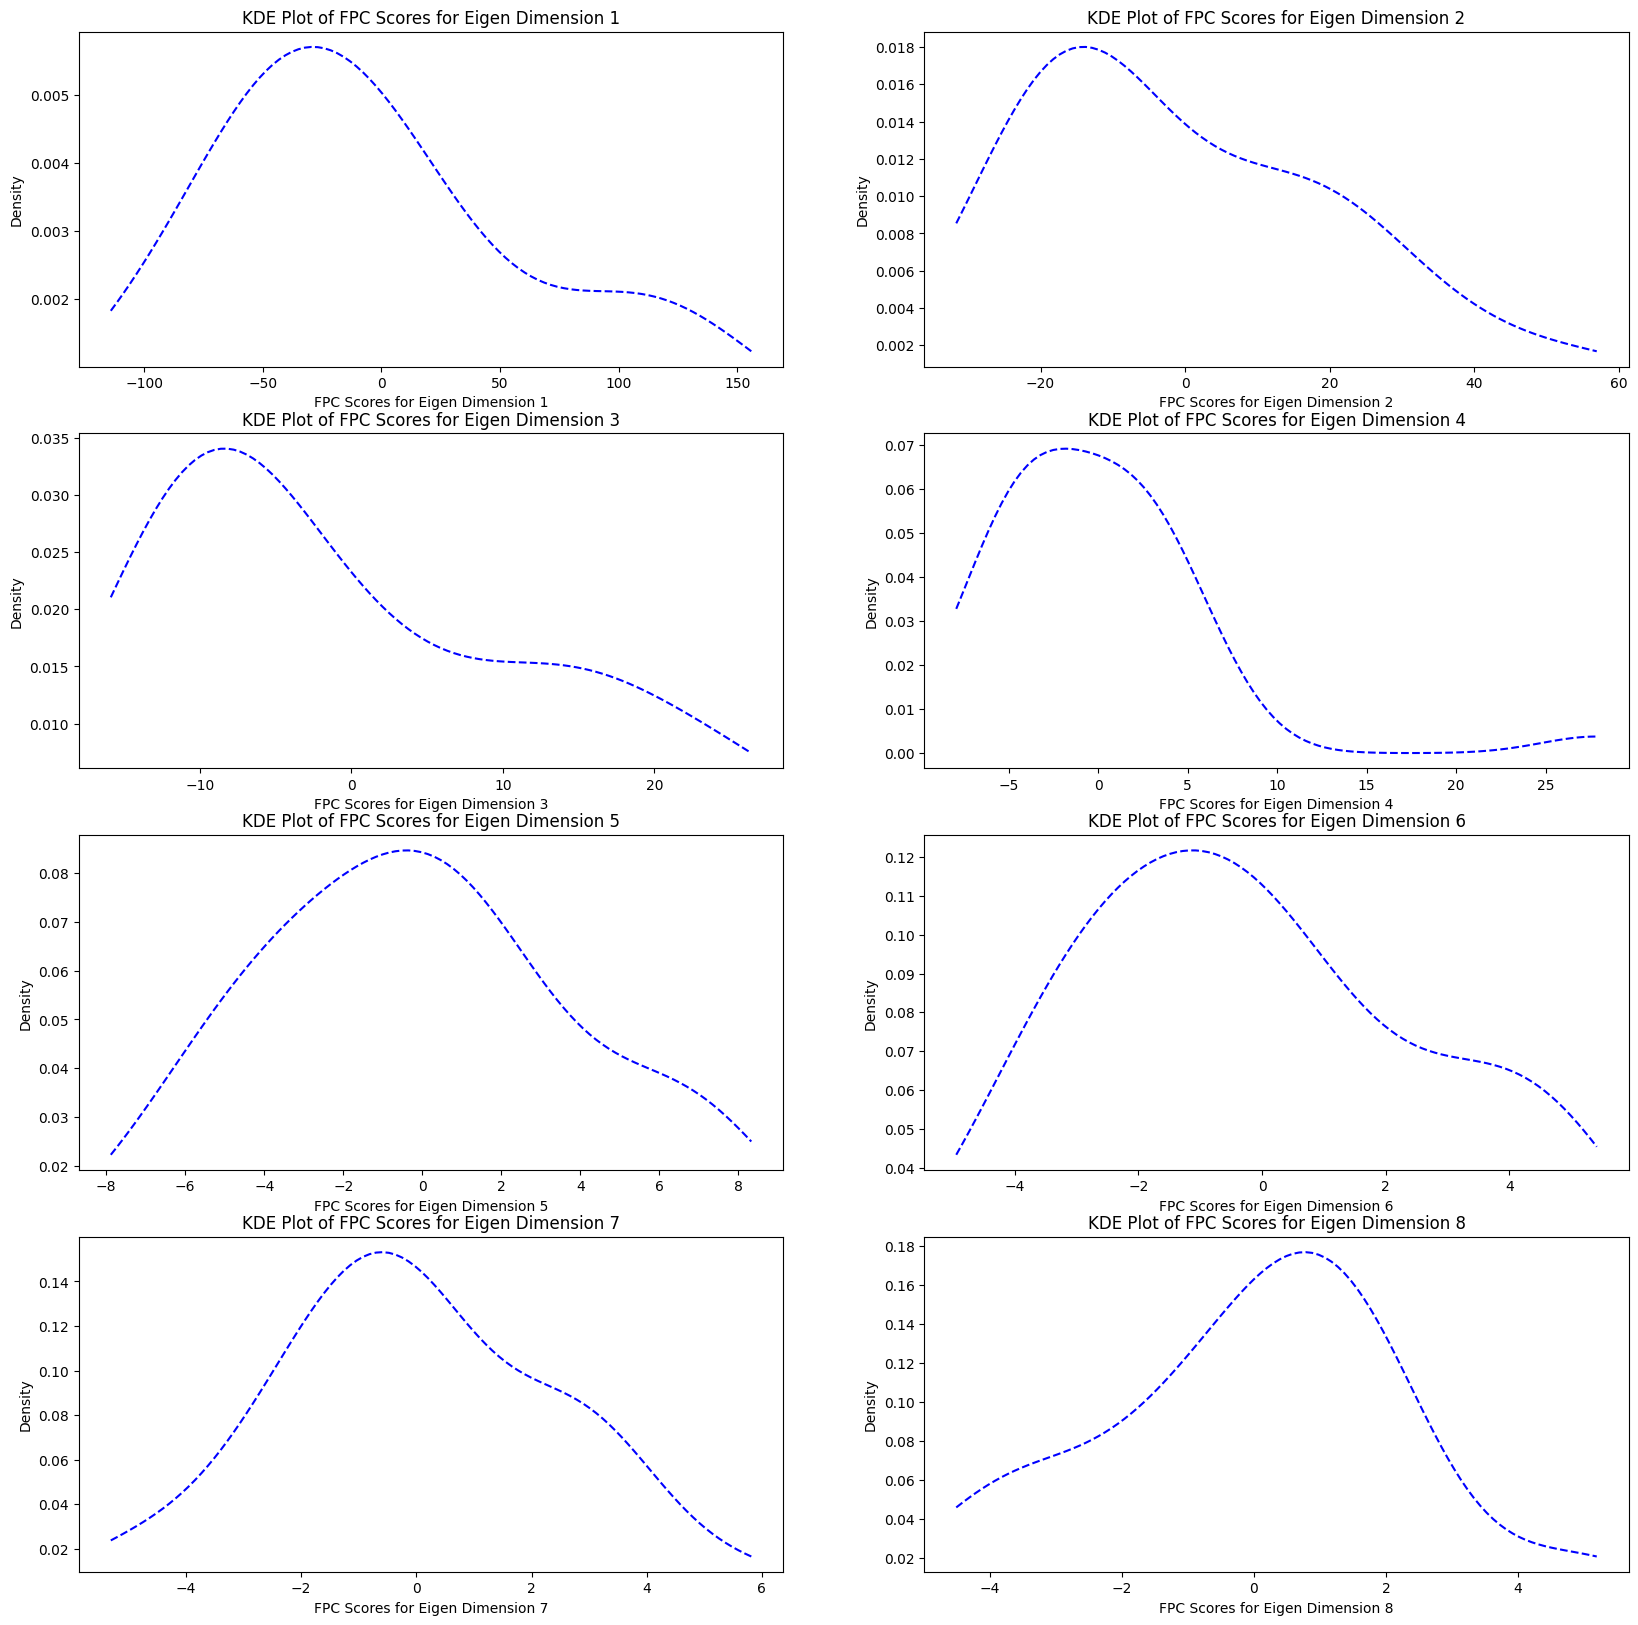

In [16]:
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

data = weather_data

data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 10, 150)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i in range(8):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()

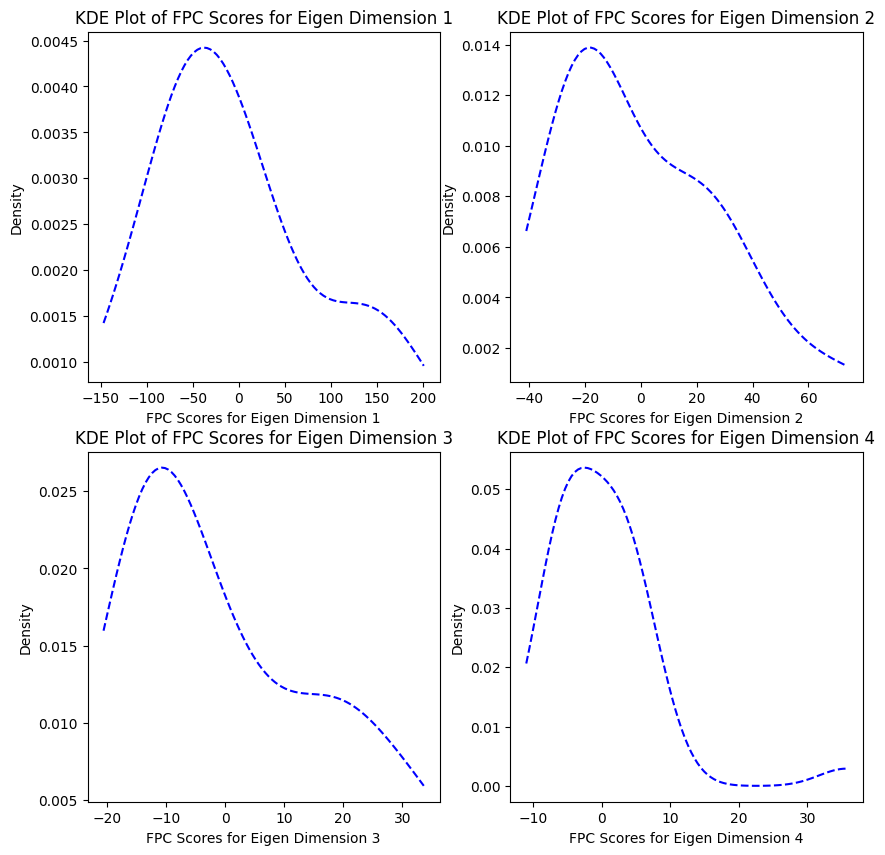

In [17]:
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 10, 250)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()



Percentage of variation explained by each eigen dimensions:  [8.78133291e-01 8.07408392e-02 2.65873572e-02 6.75354530e-03
 3.03146987e-03 1.45894179e-03 1.06861360e-03 9.01925126e-04
 7.45616191e-04 5.78400437e-04]


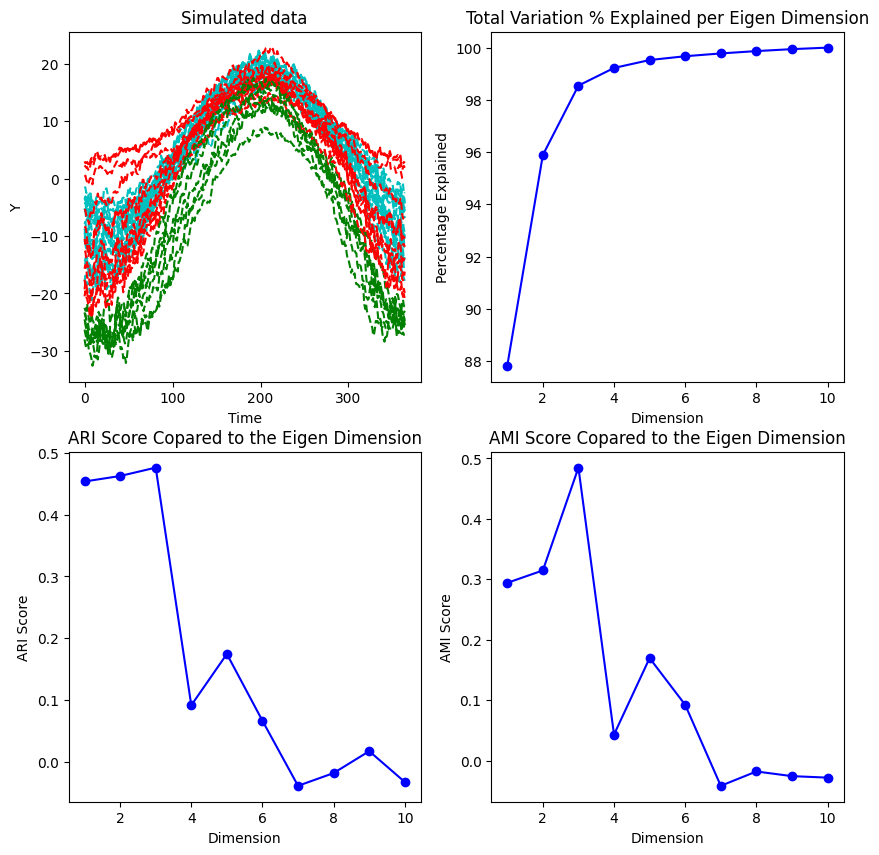

In [18]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, data, 150, true_labels, 3)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, true_labels, data)

In [19]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i))
        V = i -1
        if V == 0:
            V = 1
        break

The Eigen Dimension that explains 95% of the variance is 2


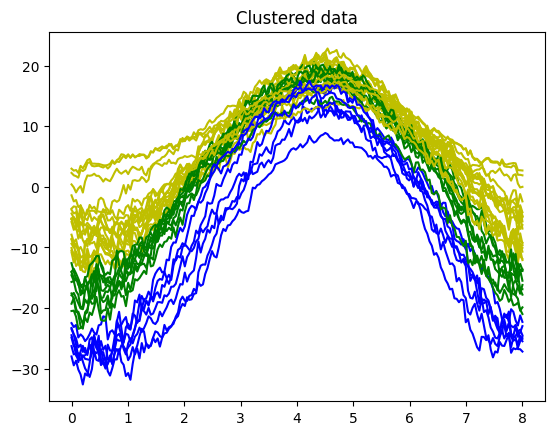

AMI score: 0.476570
ARI score: 0.344293


In [20]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, V, 200)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 3)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-b')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-y')
    elif labels[i] == 3:
        plt.plot(t, data_smooth[i], '-c')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("AMI score: %f" % adjusted_mutual_info_score(true_labels, labels))
print("ARI score: %f" % adjusted_rand_score(true_labels, labels))


In [21]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Ignore the warning
import warnings
warnings.filterwarnings("ignore")

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(data[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

fcubt_data = DenseFunctionalData(t, data)
# Build the tree
root_node = Node(fcubt_data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score for FCUBT: %f" % adjusted_rand_score(true_labels, fcubt.labels_join))
# Get the AMI
print("AMI score for FCUBT: %f" % adjusted_mutual_info_score(true_labels, fcubt.labels_join))

ARI score for FCUBT: 0.305722
AMI score for FCUBT: 0.459093


In [22]:
# Store the data in DataStore.csv
np.savetxt('Data/DataStore.csv', data, delimiter=',')

In [23]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.2" # change as needed

%reload_ext rpy2.ipython

In [24]:
# Perform FunFEM on the data

# Load packages
%R library(fda)
%R library(funHDDC)
%R library(mclust)
%R library(tidyverse)

# # Load data
%R argvals <- seq(0, 1, length.out = 365)
%R values <- t(as.matrix(read.csv('~/ProjectDocs/Project_code/simuations/Data/DataStore.csv', header = FALSE))) # nolint

# FunHDDC
%R basis <- create.bspline.basis(rangeval = c(min(argvals), max(argvals)), nbasis = 25, norder = 3) # nolint

%R data_fd <- smooth.basis(argvals = argvals, y = values, fdParobj = basis)$fd
%R res_clust <- funHDDC(data_fd, K = 3, threshold = 0.3, model = 'ABQkDk',  itermax = 2000, eps = 1e-3, init = 'kmeans') # nolint
%R pred_labels <- res_clust$class

# %R print(pred_labels)

# Write the pred_labels to a file
%R write.csv(pred_labels, file = '~/ProjectDocs/Project_code/simuations/Data/PredictedLabelsStore.csv') # nolint

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: fds

R[write to console]: Loading required package: rainbow

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: pcaPP

R[write to console]: Loading required package: RCurl

R[write to console]: Loading required package: deSolve

R[write to console]: 
Attaching package: 'fda'


R[write to console]: The following object is masked from 'package:graphics':

    matplot


R[write to console]: Registered S3 method overwritten by 'funHDDC':
  method  from
  plot.fd fda 

R[write to console]: 
Attaching package: 'funHDDC'


R[write to console]: The following object is masked from 'package:fda':

    plot.fd


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.1.8     v dplyr   1.1.0
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.3     v forcats 1.0.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::complete() masks RCurl::complete()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()
x purrr::map()      masks mclust::map()
x dplyr::select()   masks MASS::select()
   model K threshold complexity        BIC
1 ABQKDK 3       0.3        197 -98,269.52

SELECTED: model  ABQKDK  with  3  clusters.
Selection Criterion: BIC.


In [25]:
# Read Labels from PredictedLabels.csv, ignoring the header and the first column
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=1)
print("ARI score for funHDDC: %f" % adjusted_rand_score(true_labels, predicted_labels))
print("AMI score for funHDDC: %f" % adjusted_mutual_info_score(true_labels, predicted_labels))

ARI score for funHDDC: 0.294241
AMI score for funHDDC: 0.453521


In [31]:
# Load packages
%R library(fda)
%R library(funFEM)
%R library(mclust)
%R library(tidyverse)

# Load data
%R argvals <- seq(0, 1, length.out = 365)
%R values <- t(as.matrix(read.csv('~/ProjectDocs/Project_code/simuations/Data/DataStore.csv', header = FALSE))) # nolint

# FunFEM
%R basis <- create.bspline.basis(rangeval = c(min(argvals), max(argvals)), nbasis = 25, norder = 3) # nolint
%R data_fd <- smooth.basis(argvals = argvals, y = values, fdParobj = basis)$fd
%R res_clust = funFEM(data_fd,K=3, model='AkjB') # nolint # nolint: commas_linter.
%R pred_labels <- res_clust$P

# %R print(pred_labels)

# Write the pred_labels to a file
%R write.csv(pred_labels, file = '~/ProjectDocs/Project_code/simuations/Data/PredictedLabelsStore.csv') # nolint


R[write to console]: Error in .fstep(fd, T, lambda) : One cluster is almost empty!

R[write to console]: Error in funFEM(data_fd, K = 3, model = "AkjB") : 
  No reliable results to return (empty clusters in all partitions)!




Error in funFEM(data_fd, K = 3, model = "AkjB") : 
  No reliable results to return (empty clusters in all partitions)!


RInterpreterError: Failed to parse and evaluate line "res_clust = funFEM(data_fd,K=3, model='AkjB') # nolint # nolint: commas_linter.".
R error message: 'Error in funFEM(data_fd, K = 3, model = "AkjB") : \n  No reliable results to return (empty clusters in all partitions)!'

In [ ]:
# Read labels from PredictedLabels.csv, ignoring the header and the first column and getting the first four columns
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=range(1, 4))
#   Format the labels
labels = np.zeros(len(predicted_labels))
for i in range(len(predicted_labels)):
    labels[i] = np.argmax(predicted_labels[i])
print("ARI score for funFEM: %f" % adjusted_rand_score(true_labels, labels))
print("AMI score for funFEM: %f" % adjusted_mutual_info_score(true_labels, labels))
